In [8]:
!pip3 install -q cartopy netCDF4 pykrige

In [9]:
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import pandas as pd
import numpy as np
import os
from pykrige.ok import OrdinaryKriging

### Read contents of nc4 file as sample 

In [10]:
file_path = '../nasa_data/precipitation_data/2023-05-31.nc4'
dataset = nc.Dataset(file_path, 'r')

In [11]:
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
precipitation = dataset.variables['precipitation'][:]

data = {
    'latitude': np.repeat(lat, len(lon)),
    'longitude': np.tile(lon, len(lat)),
    'precipitation': precipitation.flatten()
}

In [12]:
df = pd.DataFrame(data)
df.head()

,latitude,longitude,precipitation
0,14.35,120.849998,1.400000
1,14.35,120.949997,10.775000
2,14.35,121.050003,17.934999
3,14.45,120.849998,18.590000
4,14.45,120.949997,6.965001


### Iterate through each nc4 file

In [13]:
def read_nc4_precipitation(file_path):
    ds = nc.Dataset(file_path)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    precipitation = ds.variables['precipitation'][:]  # Adjust variable name if needed
    ds.close()
    return lat, lon, precipitation

In [14]:
date_ranges = [
    pd.date_range("2023-11-01", "2015-11-30"),
    pd.date_range("2023-12-01", "2023-12-31"),
    pd.date_range("2024-01-01", "2024-01-31"),
    pd.date_range("2024-02-01", "2024-02-29"),
    pd.date_range("2024-03-01", "2024-03-31"),
    pd.date_range("2024-04-01", "2024-04-30"),
]
folder_path = '../nasa_data/precipitation_data'

In [15]:
# Create file paths for each date range
file_paths = [
    os.path.join(folder_path, f"{date.strftime('%Y-%m-%d')}.nc4")
    for date_range in date_ranges for date in date_range
]

In [127]:
# Read precipitation data from all files and store in a list of DataFrames
precip_data = []
for file_path in file_paths:
    if os.path.exists(file_path):  # Ensure file exists
        lat, lon, precipitation = read_nc4_precipitation(file_path)
        lat_grid, lon_grid = np.meshgrid(lat, lon)
        data = pd.DataFrame({
            'lat': lat_grid.ravel(),
            'lon': lon_grid.ravel(),
            'precipitation': precipitation.ravel()
        })
        precip_data.append(data)
    else:
        print(f"File {file_path} not found.")

# Combine all DataFrames into a single DataFrame for analysis
combined_precip_data = pd.concat(precip_data, ignore_index=True)

In [128]:
target_points = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')

### Spatial Interpolation by Kriging (Ordinary Kriging)

In [141]:
def interpolate_precipitation(known_data, target_points):
    ok = OrdinaryKriging(
        known_data['lon'], known_data['lat'], known_data['precipitation'],
        variogram_model='exponential',
        variogram_parameters={'range': 600, 'sill': 10, 'nugget': 1e-3}
    )
    z, ss = ok.execute('points', target_points['lon'].values, target_points['lat'].values)
    target_points['precipitation'] = np.clip(z, 0, None)
    return target_points

### Simulate

In [142]:
interpolated_precipitation = interpolate_precipitation(combined_precip_data, target_points)

In [138]:
data_range = interpolated_precipitation['precipitation'].max() - interpolated_precipitation['precipitation'].min()
print(interpolated_precipitation['precipitation'].max(), interpolated_precipitation['precipitation'].min())
print("Range of the data:", data_range)

2.366957929481201 0.8624709210401696
Range of the data: 1.5044870084410316


### Visualization

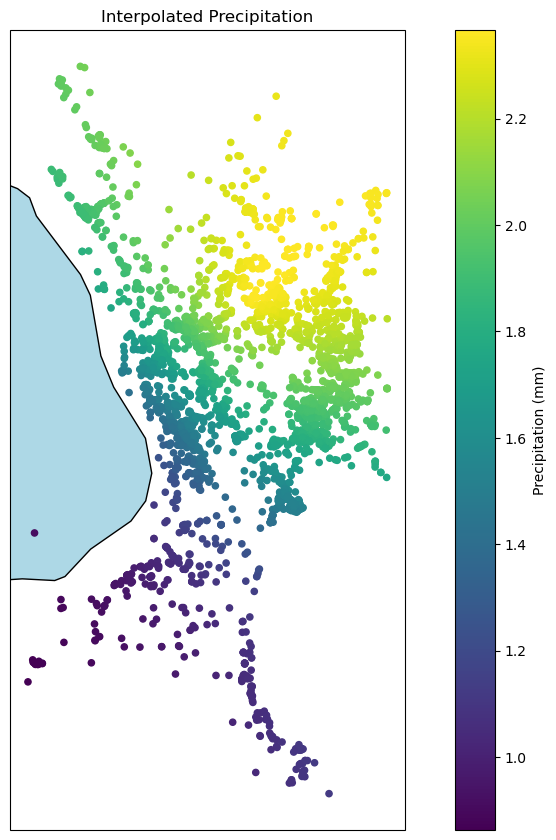

In [151]:
def plot_interpolation(data):
    # Set up the map projection and figure size
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

    # Add map features for context
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Scatter plot of interpolated data points with color based on precipitation
    sc = ax.scatter(
        data['lon'], data['lat'], c=data['precipitation'], cmap='viridis',
        marker='o', s=20, transform=ccrs.PlateCarree()
    )

    # Add a color bar to indicate precipitation levels
    #cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
     #cbar.set_label('Precipitation (mm)')
    
    # Set titles and labels
    ax.set_title('Interpolated Precipitation')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    cbar = plt.colorbar(sc)
    cbar.set_label('Precipitation (mm)')
    plt.show()

# Call the function to plot, applying the minimum precipitation filter
plot_interpolation(interpolated_precipitation)

In [ ]:
# Conclusion